In [1]:
import sys 
import matplotlib.pyplot as plt
import numpy as n
# pml = pulsedmeasurementlogic
# pmal = pulsedmasterlogic
# import pprint

# import logic.pulsed.pulse_objects as po
# import logic.pulsed.sampling_function_defs.basic_sampling_functions as functions
# import time
# import os
from PIL import Image
from numpy import asarray

from tqdm import tqdm

PODMR - repetitions at each point

Necessary classes and functions

In [2]:
class PulseSequence:
    '''
    A pulse sequence to be loaded that is made of PulseBlock instances. The pulse blocks can be repeated
    as well and multiple can be added.
    '''
    def __init__(self):
        self.pulse_dict = {'d0':[], 'd1':[], 'd2':[], 'd3':[], 'd4':[], 'd5':[], 'd6':[], 'd7':[], 'a0':[], 'a1':[]}

    def append(self, block_list):
        '''
        append a list of tuples of type: 
        [(PulseBlock_instance_1, n_repetitions), (PulseBlock_instance_2, n_repetitions)]
        '''
        for block, n in block_list:
            for i in range(n):
                for key in block.block_dict.keys():
                    self.pulse_dict[key].extend(block.block_dict[key])

    
class PulseBlock:
    '''
    Small repeating pulse blocks that can be appended to a PulseSequence instance
    '''
    def __init__(self):
        self.block_dict = {'d0':[], 'd1':[], 'd2':[], 'd3':[], 'd4':[], 'd5':[], 'd6':[], 'd7':[], 'a0':[], 'a1':[]}
    
    def append(self, init_length, channels, repetition):
        '''
        init_length in s; will be converted by sequence class to ns
        channels are digital channels of PS in swabian language
        '''
        for i in range(repetition):
            for chn in channels.keys():
                self.block_dict[chn].extend([(init_length/1e-9, channels[chn])])

def set_up_odmr(pi_pulse=100e-9):
    """ 
    @param float clock_frequency: if defined, this sets the frequency of the
                                  clock
    @param str clock_channel: if defined, this is the physical channel of
                              the clock

    @return int: error code (0:OK, -1:error)
    """
    channels = {'d0': 0.0 , 'd1': 0.0 , 'd2': 0.0 , 'd3': 0.0 , 'd4': 0.0 , 'd5': 0.0 , 'd6': 0.0 , 'd7': 0.0 , 'a0': 0.0, 'a1': 0.0}
    clear = lambda x: {i:0.0 for i in x.keys()}
    d_ch = lambda x: f'd{x}'
    a_ch = lambda x: f'a{x}'

    seq = PulseSequence()
    block_1 = PulseBlock()

    channels = clear(channels)
    channels[a_ch(pulsestreamer._laser_analog_channel)] = pulsestreamer._laser_power_voltage
    channels[d_ch(pulsestreamer._mw_switch)] = 1.0
    block_1.append(init_length = pi_pulse, channels = channels, repetition = 1)
    
    channels = clear(channels)
    channels[a_ch(pulsestreamer._laser_analog_channel)] = pulsestreamer._laser_power_voltage
    block_1.append(init_length = 1e-6, channels = channels, repetition = 1)
    
    channels = clear(channels)
    channels[d_ch(pulsestreamer._laser_channel)] = 1.0
    channels[a_ch(pulsestreamer._laser_analog_channel)] = pulsestreamer._laser_power_voltage
    channels[d_ch(pulsestreamer._pixel_start)] = 1.0 # pulse to TT channel detect
    block_1.append(init_length = 3e-6, channels = channels, repetition = 1)
    
    channels = clear(channels)
    channels[a_ch(pulsestreamer._laser_analog_channel)] = pulsestreamer._laser_power_voltage
    block_1.append(init_length = 1.5e-6, channels = channels, repetition = 1)

    seq.append([(block_1, 1)])

    pulse_dict = seq.pulse_dict

    pulsestreamer.load_swabian_sequence(pulse_dict)
    return pulsestreamer._seq

def set_up_next_trigger():
    """ 
    @param float clock_frequency: if defined, this sets the frequency of the
                                  clock
    @param str clock_channel: if defined, this is the physical channel of
                              the clock

    @return int: error code (0:OK, -1:error)
    """
    channels = {'d0': 0.0 , 'd1': 0.0 , 'd2': 0.0 , 'd3': 0.0 , 'd4': 0.0 , 'd5': 0.0 , 'd6': 0.0 , 'd7': 0.0 , 'a0': 0.0, 'a1': 0.0}
    clear = lambda x: {i:0.0 for i in x.keys()}
    d_ch = lambda x: f'd{x}'
    a_ch = lambda x: f'a{x}'

    seq = PulseSequence()
    block_1 = PulseBlock()

    channels = clear(channels)
    channels[a_ch(pulsestreamer._laser_analog_channel)] = pulsestreamer._laser_power_voltage
    block_1.append(init_length = 1e-3, channels = channels, repetition = 1)
    
    channels = clear(channels)
    channels[a_ch(pulsestreamer._laser_analog_channel)] = pulsestreamer._laser_power_voltage
    channels[d_ch(pulsestreamer._pixel_stop)] = 1.0
    block_1.append(init_length = 1e-3, channels = channels, repetition = 1)
    
    channels = clear(channels)
    channels[a_ch(pulsestreamer._laser_analog_channel)] = pulsestreamer._laser_power_voltage
    block_1.append(init_length = 1e-3, channels = channels, repetition = 1)
    
    seq.append([(block_1, 1)])

    pulse_dict = seq.pulse_dict

    pulsestreamer.load_swabian_sequence(pulse_dict)
    return pulsestreamer._seq

Run measurement

In [3]:
var_list = np.linspace(2.83e9, 2.87e9, 5, endpoint=True)
mw_power = -13
pi_pulse=274e-9
num_runs = 20000

print(mw_source_smbv.set_list(var_list, mw_power)) # 

mw_source_smbv.list_on()
laser_pulses = len(var_list)

bin_width_s = 1e-9
record_length_s = 3e-6

ret_val = time_tagger.configure_recorder(
                mode=11, # pulsed mode
                params={'laser_pulses': laser_pulses,
                        'bin_width_s': bin_width_s,
                        'record_length_s': record_length_s,
                        'max_counts': 1} )

time_tagger.start_recorder(arm=True)
set_up_next_trigger()

pulsestreamer.pulser_on(n=int(1))
while True:
    time.sleep(0.001)
    if pulsestreamer.pulse_streamer.hasFinished():
        break
podmr = set_up_odmr(pi_pulse)

for i in tqdm(range(laser_pulses)):
    pulsestreamer.pulser_on(n=num_runs, final=pulsestreamer._mw_trig_final_state)
    d =time.time()
    while True:
        if time_tagger.recorder.getHistogramIndex() > i or (time.time()-d)>2 or time_tagger.recorder.getCounts()>0:
            time.sleep(0.001)
            break

pulsestreamer.pulser_off()
mw_source_smbv.off()   

(2858500000.0, -14.0, 'cw')


100%|#######################################################################################################################################################################################################################| 5/5 [00:00<00:00,  6.61it/s]


0

In [6]:
pulsed_meas = time_tagger.get_measurements()[0]

Plot Jupyter data

[[Model]]
    (((Model(amplitude_function, prefix='l0_') * Model(physical_lorentzian, prefix='l0_')) + Model(constant_function)) + (Model(amplitude_function, prefix='l1_') * Model(physical_lorentzian, prefix='l1_')))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 140
    # data points      = 5
    # variables        = 5
    chi-square         = 1.1207e-04
    reduced chi-square = inf
    Akaike info crit   = -43.5291657
    Bayesian info crit = -45.4819762
[[Variables]]
    l0_amplitude: -0.02180360 +/- 0.00000000 (0.00%) (init = -0.004175578)
    l0_center:     2.8445e+09 +/- 0.00000000 (0.00%) (init = 2.845e+09)
    l0_sigma:      5000000.00 +/- 0.00000000 (0.00%) (init = 5000000)
    offset:        1.13553379 +/- 0.00000000 (0.00%) (init = 1.126217)
    l1_amplitude: -1.0034e-06 +/- 0.00000000 (0.00%) (init = -0.004175578)
    l1_center:     2.8475e+09 +/- 0.00000000 (0.00%) == 'l0_center+3030000.0'
    l1_sigma:      5000000.00 +/- 0.00000000 (0.00%) =

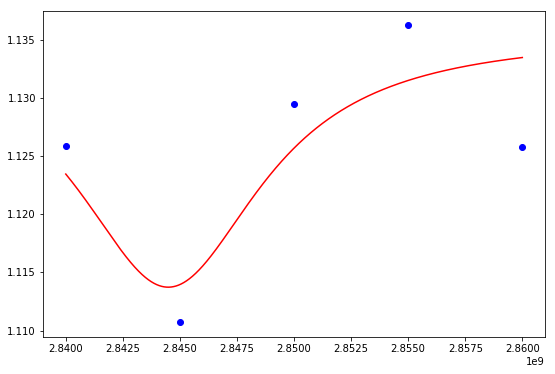

In [7]:
data,_ =afm_scanner_logic.analyse_pulsed_meas(pulsedmasterlogic.analysis_settings, pulsed_meas)

# fit = afm_scanner_logic._fitlogic.make_lorentzian_fit(var_list,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentzian_dip)
fit = afm_scanner_logic._fitlogic.make_lorentziandouble_fit(var_list,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentziandouble_N15)
print(fit.fit_report())
# lm,_ = fitlogic.make_lorentzian_model()
lm,_ = fitlogic.make_lorentziandouble_model()
plt.plot(var_list, data,'bo')
x = np.linspace(var_list[0],var_list[-1],10000, endpoint=True)
plt.plot(x, lm.eval(fit.params, x=x),'r-')
plt.show()

Plot SPM data

In [6]:
d = afm_scanner_logic._pulsed_scan_array['pulsed_fw']['data']
x = afm_scanner_logic._pulsed_scan_array['pulsed_fw']['coord2_arr']

In [2]:
qafm = afm_scanner_logic._qafm_scan_array

In [5]:
print(qafm['fit_param_fw']['data'])

[[2.75784652 2.75817103 2.75834419 ... 2.76018119 2.76015917 2.76020889]
 [2.75802477 2.75821205 2.75834965 ... 2.76070879 2.76068542 2.76079577]
 [2.75821342 2.7583453  2.7584533  ... 2.76052883 2.76045252 2.76037144]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


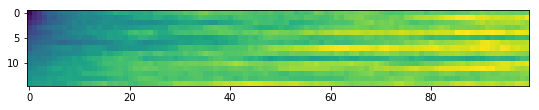

In [12]:
plt.imshow(qafm['fit_param_fw']['data'][:15,:])
plt.show()

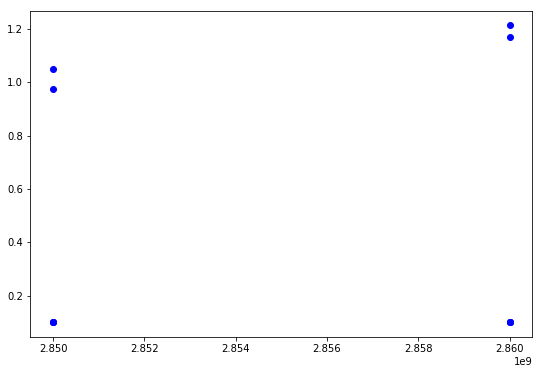

In [9]:
scale=0
for i in range(5):
    data = d[i,0,:]
#     fit = afm_scanner_logic._fitlogic.make_lorentzian_fit(x,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentzian_dip)
#     print(fit.fit_report())
#     lm,_ = fitlogic.make_lorentziandouble_model()
    scale += np.median(data)*0.05
    plt.plot(x, data+scale,'bo')
    x1 = np.linspace(x[0],x[-1],10000, endpoint=True)
#     plt.plot(x1, lm.eval(fit.params, x=x1)+scale,'r-')

plt.show()

In [39]:
(fit.params['l1_center']+fit.params['l0_center'])/2

2850308429.723922

In [45]:
fit_param = np.zeros((d.shape[0],d.shape[1]))
for i in tqdm(range(d.shape[0])):
    for j in range(d.shape[1]):
        data = d[i,j,:]
        fit = afm_scanner_logic._fitlogic.make_lorentzian_fit(x,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentzian_dip)
        fit_param[i,j] = (fit.params['center'])#+fit.params['l0_center'])/2

100%|#####################################################################################################################################################################################################################| 20/20 [00:08<00:00,  2.41it/s]


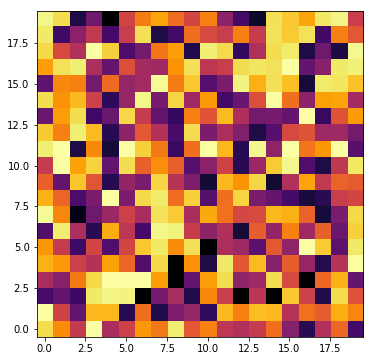

In [46]:
plt.imshow(fit_param, cmap=plt.get_cmap('inferno'), origin='lower',vmin=2850308429.723922-12e6, vmax=2850308429.723922+10e6)
plt.show()

In [42]:
qafm['Height(Dac)_fw']

{'data': array([[4.35065120e-07, 4.13793013e-07, 4.43069498e-07],
       [4.18502625e-07, 4.23897973e-07, 4.54431568e-07],
       [4.20701359e-07, 4.32204569e-07, 4.73903073e-07]]), 'coord0_arr': array([5.0e-06, 5.5e-06, 6.0e-06]), 'coord1_arr': array([5.0e-06, 5.5e-06, 6.0e-06]), 'corr_plane_coeff': [0.0, 0.0, 0.0], 'image_correction': False, 'measured_units': 'µm', 'scale_fac': 1e-06, 'si_units': 'm', 'nice_name': 'Height', 'params': {'Parameters for': 'QAFM measurement', 'axis name for coord0': 'X', 'axis name for coord1': 'Y', 'measurement plane': 'XY', 'coord0_start (m)': 5e-06, 'coord0_stop (m)': 6e-06, 'coord0_num (#)': 3, 'coord1_start (m)': 5e-06, 'coord1_stop (m)': 6e-06, 'coord1_num (#)': 3, 'ESR Frequency start (Hz)': 2820000000.0, 'ESR Frequency stop (Hz)': 2880000000.0, 'ESR Frequency points (#)': 60, 'ESR Count Frequency (Hz)': 200.0, 'ESR MW power (dBm)': -16.0, 'ESR Measurement runs (#)': 5, 'Expect one resonance dip': True, 'Optimize Period (s)': None, 'AFM integratio

In [39]:
afm_scanner_logic._counter.countrate.startFor(1e9)
afm_scanner_logic._counter.countrate.waitUntilFinished()
afm_scanner_logic._counter.countrate.getData()

array([121000.])

CW Analysis

In [28]:
d = afm_scanner_logic._esr_scan_array['esr_fw']['data']
x = afm_scanner_logic._esr_scan_array['esr_fw']['coord2_arr']

100%|#####################################################################################################################################################################################################################| 20/20 [00:27<00:00,  1.40s/it]


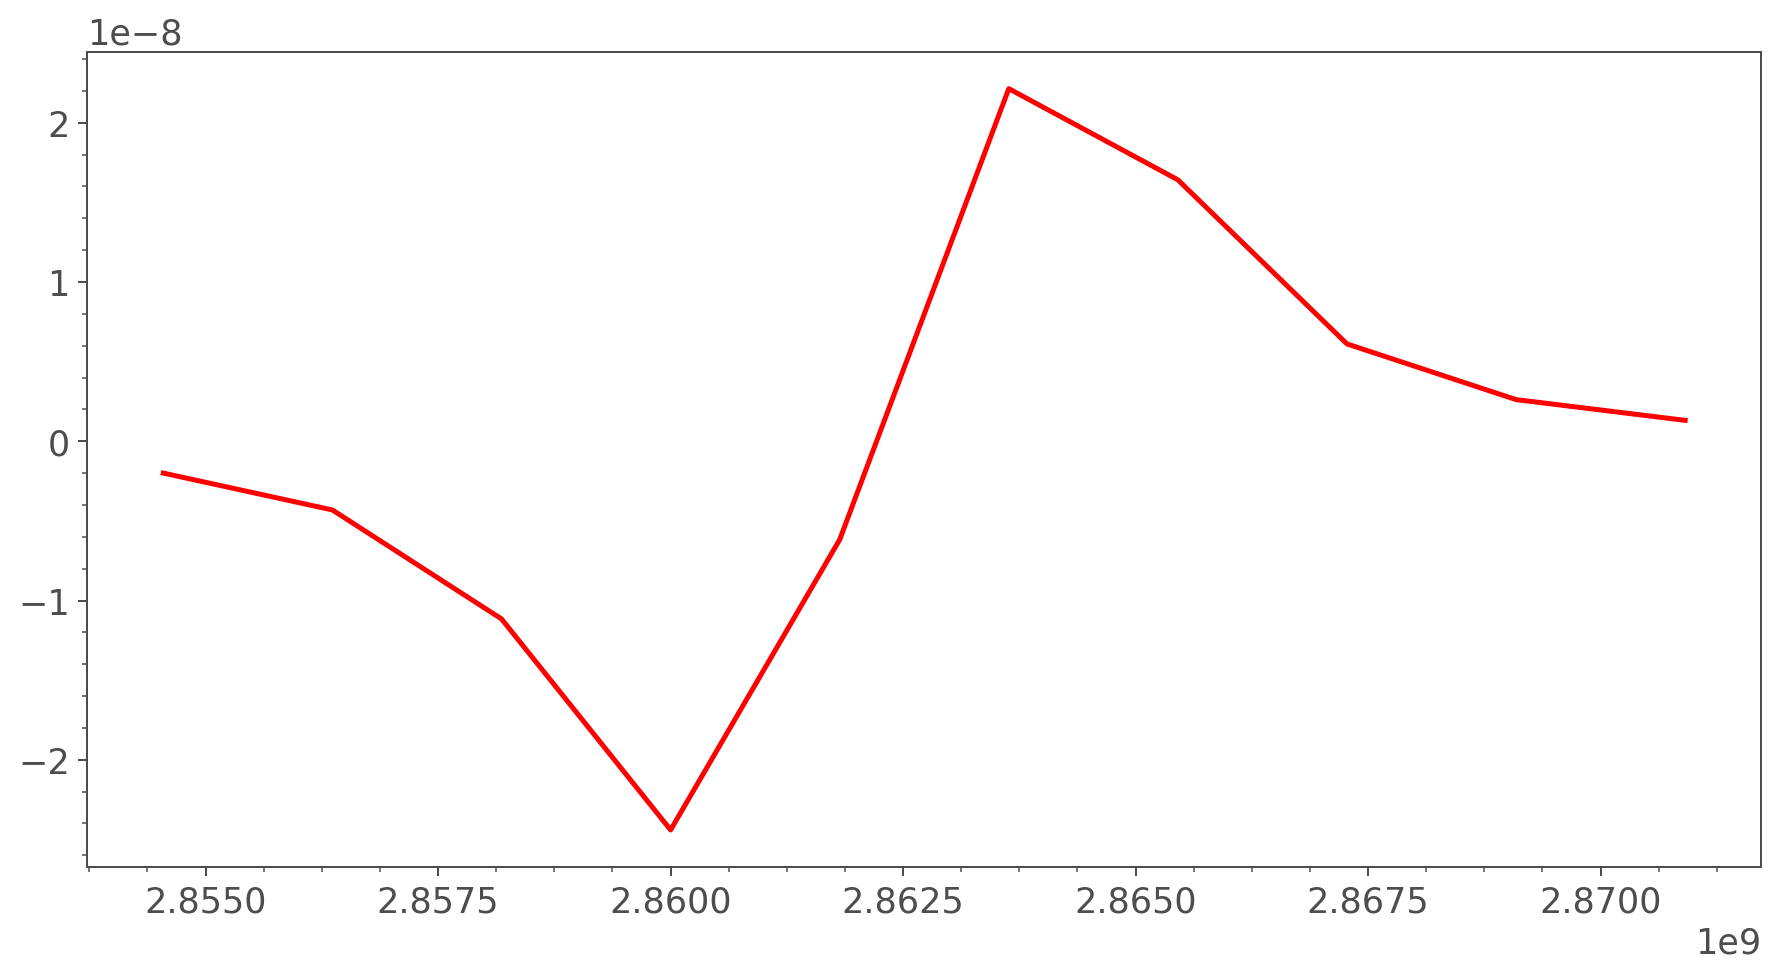

In [88]:
scale = 0
scale_dx = 0
# plt.figure(figsize=(3,9))
for i in range(1):
    data = d[1,i,:]
    data =(data - np.mean(data))/np.max(data)
    fit = afm_scanner_logic._fitlogic.make_lorentziandouble_fit(x,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentziandouble_dip)
#     print(fit.fit_report())
    lm,_ = fitlogic.make_lorentziandouble_model()
    scale += np.median(data)*0.2
#     plt.plot(x, data+scale,'b-')

    x1 = np.linspace(x[0],x[-1],100, endpoint=True)
    dx1 = x1[1]-x1[0]
    dx = x[1]-x[0]
    
    y_fit = lm.eval(fit.params, x=x1)
    y1 = np.gradient(y_fit, dx1)
    y2 = np.gradient(data, dx)
    scale_dx += np.max(y2)*1.5 * 0
    
#     plt.plot(x1, (y_fit),'r-')
    rng = [30,40]
    plt.plot(x1[rng[0]:rng[1]], y1[rng[0]:rng[1]]+scale_dx,'r-')

plt.show()

In [35]:
fit_param = np.zeros((d.shape[0],d.shape[1]))
for i in tqdm(range(d.shape[0])):
    for j in range(d.shape[1]):
        data = d[i,j,:]
        fit = afm_scanner_logic._fitlogic.make_lorentziandouble_fit(x,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentziandouble_dip)
        fit_param[i,j] = (fit.params['l1_center']-fit.params['l0_center'])/1
        if abs(fit.params['l1_contrast'])<2:
            fit_param[i,j] = 2.975e9-2.800e9

 95%|##########################################################################################################################################################################################################3          | 19/20 [00:26<00:01,  1.20s/it]

100%|#####################################################################################################################################################################################################################| 20/20 [00:27<00:00,  1.38s/it]


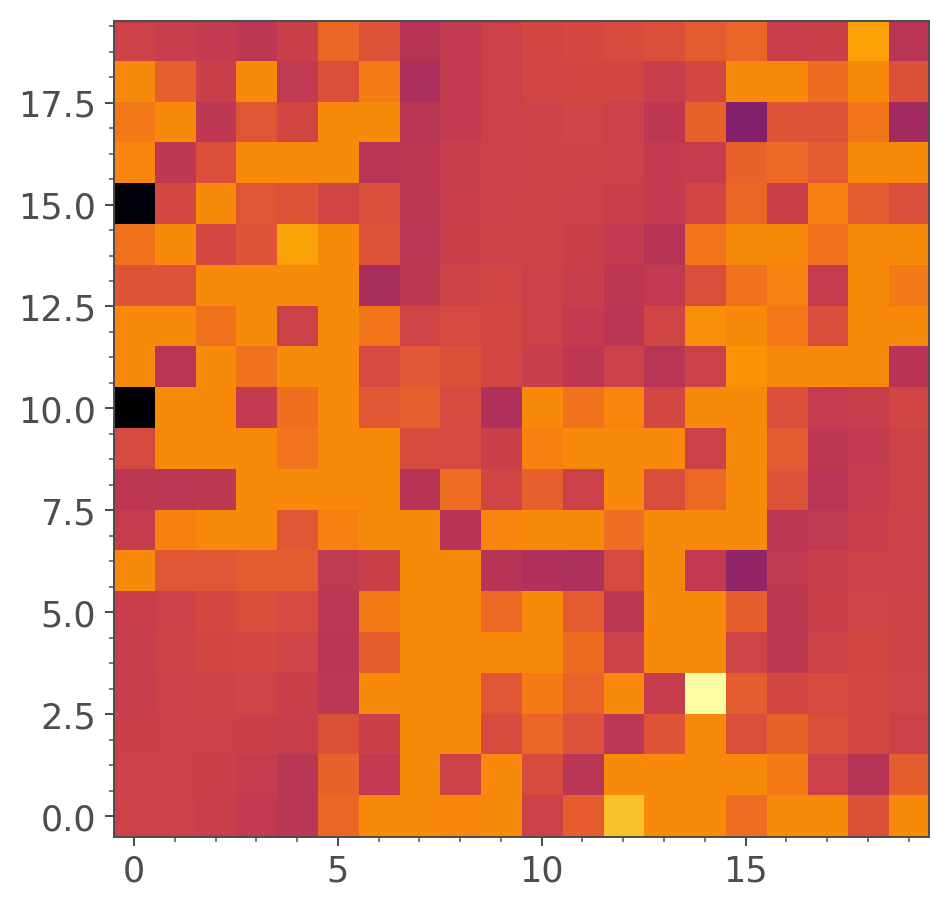

In [36]:
plt.imshow(fit_param, cmap=plt.get_cmap('inferno'), origin='lower')#,vmin=2850308429.723922-6e6, vmax=2850308429.723922+5e6)
plt.show()

In [ ]:
def tracking_analysis(pulsed_ret0, var_list, coord1_num, coord0_num, 
                      line_num, index, slope2_podmr, res_freq_array,p, prev):
    
        visibility = (pulsed_ret0[1] - pulsed_ret0[0])/(pulsed_ret0[1] + pulsed_ret0[0])
        s = -1/slope2_podmr

        if line_num==0 and index==0:
            coord = (line_num,index)
        elif line_num!=0 and index==0:
            coord = (line_num-1,index)
        elif index!=0:
            coord = (line_num,index-1)

#         new_res_freq = (new_slope + res_freq_array[0,0] * slope2_podmr)/slope2_podmr
#         new_res_freq = res_freq_array[coord] + visibility * slope2_podmr
        if prev == 0.0:
            prev = res_freq_array[coord]
#             print(line_num,index,coord)
            
        new_res_freq = ((visibility -(prev * slope2_podmr))/slope2_podmr) 
        
#         new_res_freq = prev + visibility * (s)
        
#         delta = res_freq_array[coord] - new_res_freq
#         new_res_freq += delta*p

        return new_res_freq, visibility, slope2_podmr

## Tracking analysis testing

In [53]:
def tracking_analysis(pulsed_ret0, coord1_num, coord0_num, 
                      line_num, index, slope2_podmr, res_freq_array, prev):
    
        visibility = (pulsed_ret0[1] - pulsed_ret0[0])/(pulsed_ret0[1] + pulsed_ret0[0])

        estimation_freq =  prev - visibility/slope2_podmr
        
        return estimation_freq, visibility, slope2_podmr

def tracking_analysis_point(pulsed_ret0, slope2_podmr, prev):
        visibility = (pulsed_ret0[1] - pulsed_ret0[0])/(pulsed_ret0[1] + pulsed_ret0[0])
        
        estiamtion_freq =  prev - visibility/slope2_podmr
        

        return estiamtion_freq, visibility
    
def measure_two_points(lm, params, x1):
    y1 = lm.eval(params, x = x1)
    return y1
    
def twoD_sin(point_num, coord0_num, freq, phase, line_num, coord1_num):
    sig = np.sin(2 * np.pi * freq * point_num/coord0_num + phase)
#     sig = np.sin(2 * np.pi * freq * line_num/coord1_num + phase)
    return sig

In [80]:
# load the image
image = Image.open('C:\\Users\\yy3\\anaconda3\\envs\\qudi\\Lib\\site-packages\\skimage\\data\\coins.png')
# convert image to numpy array
fdata = asarray(image)

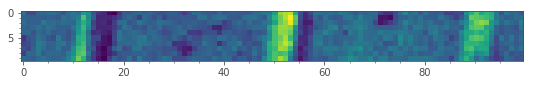

In [52]:
plt.imshow(fdata[:10,:100])
plt.show()

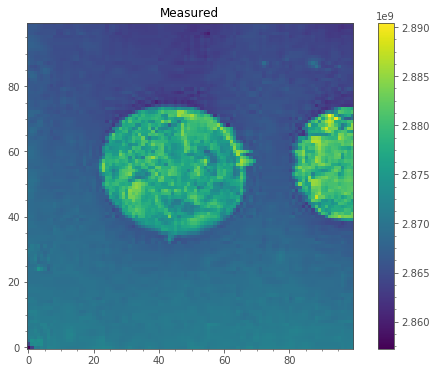

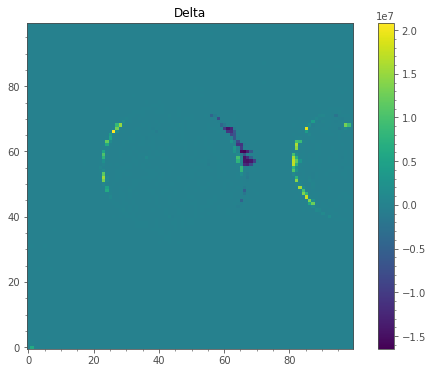

Mean: 98686.02113831406
Median: 2727.5823628902435
Mean without first line: 99630.12203947506
Mean only first line: 5220.03192337513


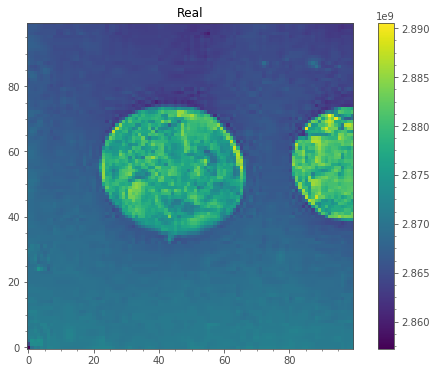

In [83]:
coord0 = 200
coord1 = 200

data =fdata[:100,:100]
coord0 = data.shape[1]
coord1 = data.shape[0]

# true_res = np.ones([coord1,coord0]) * 2.87e9
true_res = ((data/np.mean(data)-np.max(data/np.mean(data))/2)*20e6) + 2.87e9

# meas_res = np.ones([coord1,coord0]) * 2.87e9
meas_res = np.zeros([coord1,coord0])
meas_res[0,0] = true_res[0,0]
fwhm = 11e6

lm,_ = fitlogic.make_lorentzian_model()
params = lm.make_params()
params['amplitude'].value = -30e3
params['offset'].value = 100e3
params['sigma'].value = fwhm/2

# l = 4
# shifting_freq = 5
# freq_shift = (fwhm * twoD_sin(0, coord0, shifting_freq, 0, 0, coord1)) / l
# freq_shift = 0 
# true_res0 = true_res[0,0] + freq_shift 
# res_estimate = true_res0
n_runs = 4
K = 4.6e-08
# ph=5

for j in range(coord1):
    for i in range(coord0):
#         freq_shift = (fwhm * twoD_sin(i, coord0, shifting_freq, 2*np.pi*j/coord1*ph, j, coord1)) / l + (np.random.random()*2e6)
#         true_res[j,i] += freq_shift 
        params['center'].value = true_res[j,i] # updates the model to keep up with true data  
        delta = params['fwhm']/2

        line_num = j
        index = i
        if line_num==0 and index==0:
            coord = (line_num,index)
        elif line_num!=0 and index==0:
            coord = (line_num-1,index)
        elif index!=0:
            coord = (line_num,index-1)
        res_estimate = meas_res[coord]
        
        for n in range(n_runs):
            var_list = np.array([res_estimate-delta, res_estimate+delta])
            pulsed_ret0 = measure_two_points(lm, params, var_list)        
            res_estimate,vis,K = tracking_analysis(pulsed_ret0, coord1, coord0, j, i, K, meas_res,res_estimate)
            if np.isclose(vis,0,rtol=0.001):
                meas_res[j,i] = res_estimate
                break
            meas_res[j,i] = res_estimate


ax = plt.subplot()
im = ax.imshow(meas_res, origin='lower')
plt.title('Measured')
plt.colorbar(im)
plt.show()

ax = plt.subplot()
im = ax.imshow(true_res-meas_res, origin='lower')
plt.title('Delta')
plt.colorbar(im)
plt.show()

ax = plt.subplot()
im = ax.imshow(true_res, origin='lower')
plt.title('Real')
plt.colorbar(im)
plt.show()
print(f'Mean: {np.mean(abs(true_res[:,:]-meas_res[:,:]))}')
print(f'Median: {np.median(abs(true_res[:,:]-meas_res[:,:]))}')
print(f'Mean without first line: {np.mean(abs(true_res[:,1:]-meas_res[:,1:]))}')
print(f'Mean only first line: {np.mean(abs(true_res[:,0]-meas_res[:,0]))}')

4.6e-08
2.87


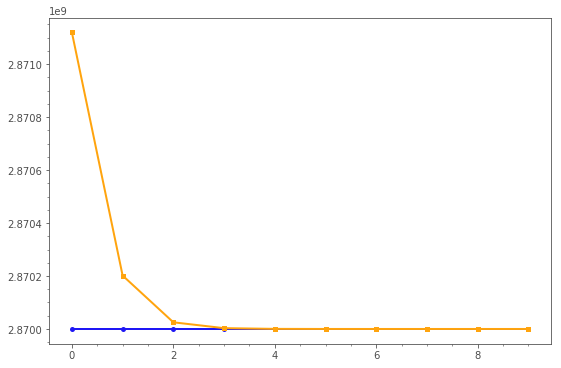

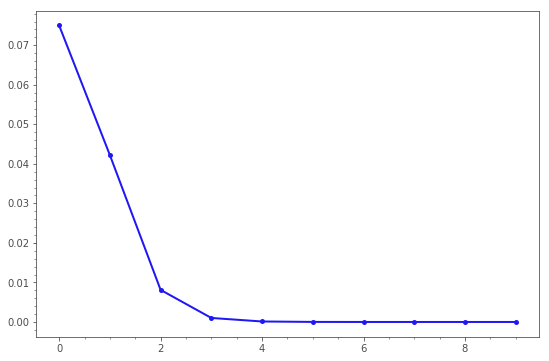

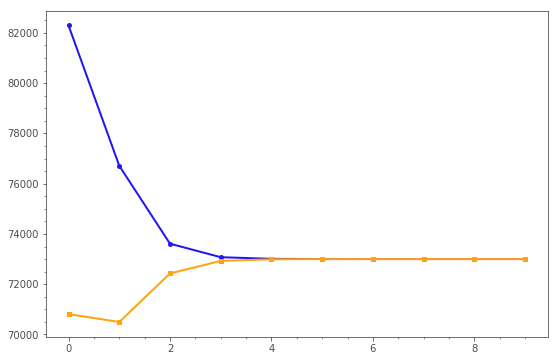

In [84]:
num_runs = 10

visibility = np.zeros(num_runs)
res_delta = np.zeros(num_runs)
true_res = np.ones(num_runs) * 2.87e9
meas_res = np.zeros(num_runs)
pulse_ret = np.zeros([2, num_runs])
fwhm = 11e6

lm,_ = fitlogic.make_lorentzian_model()
params = lm.make_params()
params['amplitude'].value = -30e3
params['offset'].value = 100e3
params['sigma'].value = fwhm/2
params['center'].value = true_res[0]

freq_shift = fwhm / 4
res_estimate = true_res[0] + freq_shift
meas_res[0] = res_estimates
delta = params['fwhm']/6

slope = 4.6e-08

print(slope)
print(res_estimates/1e9)

for n in range(num_runs):
    var_list = np.array([res_estimate-delta, res_estimate+delta])
        
    pulsed_ret0 = measure_two_points(lm, params, var_list)
    
    res_estimate, vis = tracking_analysis_point(pulsed_ret0, slope, res_estimate)

    meas_res[n] = res_estimate
    visibility[n] = vis
    pulse_ret[:,n] = pulsed_ret0


plt.plot(np.arange(num_runs),true_res)
plt.plot(np.arange(num_runs),meas_res)
plt.show()

plt.plot(np.arange(num_runs),visibility)
plt.show()
# print(visibility)

plt.plot(np.arange(num_runs),pulse_ret[1], label='C1')
plt.plot(np.arange(num_runs),pulse_ret[0], label='C2')
plt.show()
# print(pulse_ret)
# plt.plot(res_delta[::])
# plt.show()


4.59300437304979e-08


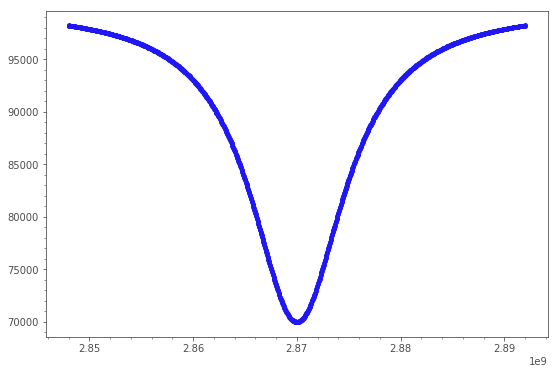

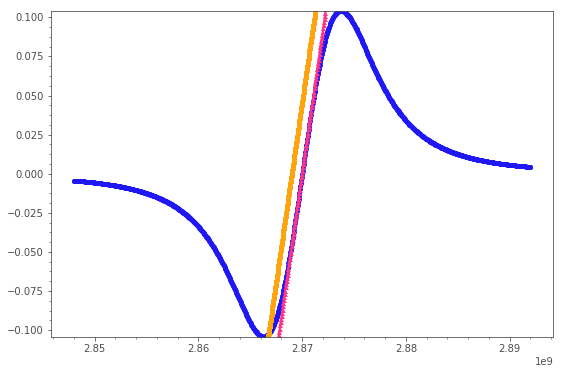

In [7]:
def vis(lm, param, res, delta):
    c2, c1 = lm.eval(param, x = np.array([res-delta, res+delta]))
    return (c1-c2)/(c1+c2)

lm,_ = fitlogic.make_lorentzian_model()
params = lm.make_params()
fwhm = 11e6
params['amplitude'].value = -30e3
params['offset'].value = 100e3
params['sigma'].value = fwhm/2
params['center'].value = 2.87e9
x = np.linspace(2.87e9-fwhm*2,2.87e9+fwhm*2,1001)
y = lm.eval(params,x=x)
plt.plot(x,y)
plt.show()

vis_arr = np.array([vis(lm, params, x, fwhm/4) for x in x])
plt.plot(x, vis_arr)
# plt.show()

slope = np.gradient(vis_arr, x)[int(len(x)/2)]
print(slope)
# plt.plot(x, slope)
# plt.show()
m = slope
y = m*x + (-m*(2.87e9-1e6))
# x = (vis - (-m*prev)) / m
plt.plot(x,y)

y = m*x + (-m*(2.87e9))
# x = (vis - (-m*prev)) / m
plt.plot(x,y)

plt.ylim(vis_arr.min(), vis_arr.max())
plt.show()